<a href="https://colab.research.google.com/github/kaitsidis/ML102/blob/main/Pnevmonia_DensNet_82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Εκπαίδευση Μοντέλου DenseNet με Ακτινογραφίες
μοντέλο **DenseNet** με ακτινογραφίες σε gray-scale,

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Βιβλιοθήκες που απαιτούνται**

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

Ορισμός path και φόρτωση των label
δημιουργία dictionary για την βαρύτητα των κατηγοριών

In [4]:
# Set paths for training and testing data
train_data_dir = '/content/drive/MyDrive/ML102/train_images/train_images'
test_data_dir  = '/content/drive/MyDrive/ML102/test_images_all'
labels_file    = '/content/drive/MyDrive/ML102/labels_train.csv'

# Φόρτωση του αρχείου labels
labels = pd.read_csv(labels_file)
labels['class_id'] = labels['class_id'].astype(str)  # Μετατροπή σε string για χρήση με ImageDataGenerator

# Υπολογισμός βαρύτητας ανά κατηγορία
class_weights = labels['class_id'].value_counts(normalize=True).to_dict()

### Προαιτημασία δεδομένων

In [8]:
batch_size = 128
# Δημιουργία ImageDataGenerator για εκπαίδευση και επικύρωση

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=50,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=train_data_dir,
    x_col='file_name',
    y_col='class_id',
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=train_data_dir,
    x_col='file_name',
    y_col='class_id',
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation'
)

Found 3738 validated image filenames belonging to 3 classes.
Found 934 validated image filenames belonging to 3 classes.


### Δημιουργία Μοντέλου DenseNet

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Conv2D,  Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam


input_tensor = Input(shape=(224, 224, 1))
# Wrap tf.image.grayscale_to_rgb in a Lambda layer
x = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(input_tensor)

# Load pre-trained DenseNet121 with 'imagenet' weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=x)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.7)(x)
x = Dense(3, activation='softmax')(x)  # 3 κατηγορίες

#Create the final model
model = Model(inputs=input_tensor, outputs=x)

#Χρήση του Nadam ως optimizer
nadam_optimizer = Nadam(learning_rate=0.0001)  # Μπορείτε να προσαρμόσετε τον ρυθμό μάθησης αν χρειαστεί

# Συμπλήρωση του μοντέλου
model.compile(optimizer=nadam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Δημιουργία του Nadam optimizer με προσαρμοσμένες παραμέτρους
#nadam_optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

# Συμπλήρωση του μοντέλου
#model.compile(optimizer=nadam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ lambda_1[0][0]         │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat  

 Total params: 7,169,091 (27.35 MB)

 Trainable params: 7,085,443 (27.03 MB)

 Non-trainable params: 83,648 (326.75 KB)

### Εκπαίδευση Μοντέλου

### Αξιολόγηση και Οπτικοποίηση Αποτελεσμάτων

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 402s 6s/step - accuracy: 0.4079 - loss: 3.9284 - val_accuracy: 0.4925 - val_loss: 3.2803 - learning_rate: 1.0000e-04
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6286 - loss: 3.0542 - val_accuracy: 0.6049 - val_loss: 2.8592 - learning_rate: 1.0000e-04
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6816 - loss: 2.7281 - val_accuracy: 0.6370 - val_loss: 2.6494 - learning_rate: 1.0000e-04
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7039 - loss: 2.5531 - val_accuracy: 0.6799 - val_loss: 2.4785 - learning_rate: 1.0000e-04
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7147 - loss: 2.3855 - val_accuracy: 0.6617 - val_loss: 2.3817 - learning_rate: 1.0000e-04
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7494 - loss: 2.2476 - val_accuracy: 0.6627 - val_loss: 2.3555 - learning_rate: 1.0000e-04
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7578 - loss: 2.1305 - 

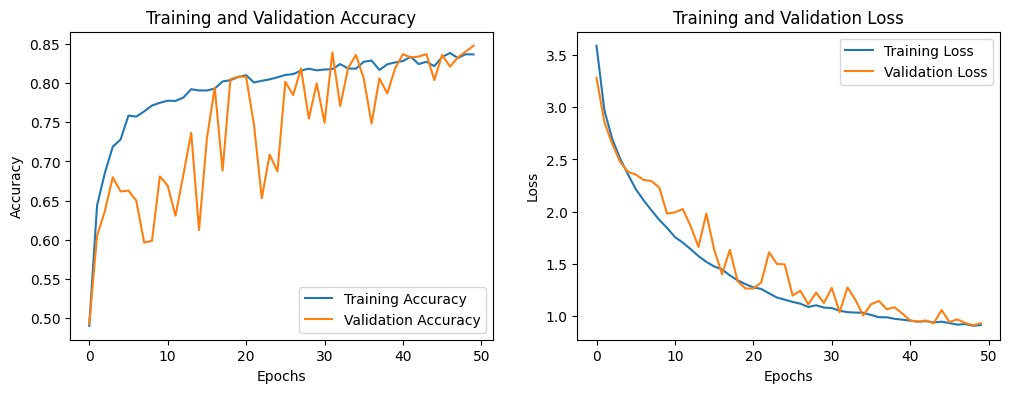

Validation Accuracy: 0.8480, Validation Loss: 0.9333


In [10]:

from tensorflow.keras.callbacks import ReduceLROnPlateau
model_file='/content/drive/MyDrive/ML102/models/densenet_model_e50bs128.keras' # Change the file extension to .keras

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Εκπαίδευση του μοντέλου
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,  # Αυξήστε τις εποχές αν χρειαστεί
        class_weight=class_weights,
    batch_size=batch_size,
    verbose=1,
    callbacks=[
        EarlyStopping(patience=30, restore_best_weights=True),
        ModelCheckpoint(model_file, save_best_only=True),
        lr_scheduler]
)
#Αναμενόμενα Αποτελέσματα
model.save('/content/drive/My Drive/ML102/Saved_densenet_model_e50bs128.keras')
# Εκτύπωση summary του μοντέλου


# Αξιολόγηση του μοντέλου
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}')
# Οπτικοποίηση της ακρίβειας και της απώλειας
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Εκτύπωση τελικών αποτελεσμάτων
val_accuracy = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
print(f'Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}')




### Αξιολόγηση Δοκιμής

In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data_dir  = '/content/drive/MyDrive/ML102/test_images_all' # Assuming your test images are in this directory
test_generator = test_datagen.flow_from_directory(
    test_data_dir, # Use the correct path for your test images
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode=None,
    shuffle=False
)

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Αποθήκευση αποτελεσμάτων
results_df = pd.DataFrame({'file_name': test_generator.filenames, 'predicted_class': predicted_classes})
results_df.to_csv('/content/drive/MyDrive/ML102/train_csvs/kda_results_model_e50bs128.csv', index=False)

Found 1168 images belonging to 1 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step
